In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import losses


# Sentiment analysis

In [2]:
# url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# dataset = tf.keras.utils.get_file("aclImdb_v1", url,
#                                     untar=True, cache_dir='.',
#                                     cache_subdir='')

# dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')



In [3]:
dataset_dir = os.path.join("C:/Users/Admin/Desktop/TensorFlow/aclImdb")

In [4]:
os.listdir(dataset_dir)



['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')

os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [6]:
simple_file = os.path.join(train_dir, 'pos/1_7.txt')

with open(simple_file) as f:
    print(f.read())

If you like adult comedy cartoons, like South Park, then this is nearly a similar format about the small adventures of three teenage girls at Bromwell High. Keisha, Natella and Latrina have given exploding sweets and behaved like bitches, I think Keisha is a good leader. There are also small stories going on with the teachers of the school. There's the idiotic principal, Mr. Bip, the nervous Maths teacher and many others. The cast is also fantastic, Lenny Henry's Gina Yashere, EastEnders Chrissie Watts, Tracy-Ann Oberman, Smack The Pony's Doon Mackichan, Dead Ringers' Mark Perry and Blunder's Nina Conti. I didn't know this came from Canada, but it is very good. Very good!


In [7]:
#remove additional forder

# remove_dir = os.path.join(train_dir,'unsup')
# shutil.rmtree(remove_dir)

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
      "aclImdb/train",
      batch_size = batch_size,
      validation_split=0.2,
     seed=seed,
     subset = "training"
)



Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review: ", text_batch.numpy()[i]) 
        print("label: ", label_batch.numpy()[i])
        print()

Review:  b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
label:  0

Review:  b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they ge

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
label 1 corresponds to pos


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    
    'aclImdb/train',
    batch_size=batch_size,
    seed=seed,
    subset='validation',
    validation_split=0.2
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(

  'aclImdb/train',
batch_size= batch_size

)

Found 25000 files belonging to 2 classes.


As you saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [13]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens = max_features,
    output_mode='int',
    output_sequence_length=sequence_length

)

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [2]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
# print("Review: ", first_review)
# print("Label: ",raw_train_ds.class_names[first_label])
# print("Vectorized review: ", vectorize_text(first_review, first_label))

You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [18]:
print("1287---->", vectorize_layer.get_vocabulary()[1287])
# print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287----> lovely


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configure the dataset for performance

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create The Model

In [23]:
embedding_dim = 16
model =tf.keras.Sequential([
    layers.Embedding(max_features + 1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [25]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

In [26]:
epochs = 10
history = model.fit(
train_ds,
validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 9s 12ms/step - loss: 0.6632 - binary_accuracy: 0.6993 - val_loss: 0.6141 - val_binary_accuracy: 0.7742
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5483 - binary_accuracy: 0.8022 - val_loss: 0.4983 - val_binary_accuracy: 0.8228
Epoch 3/10
625/625 [==============================] - 2s 2ms/step - loss: 0.4449 - binary_accuracy: 0.8460 - val_loss: 0.4203 - val_binary_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3779 - binary_accuracy: 0.8669 - val_loss: 0.3741 - val_binary_accuracy: 0.8608
Epoch 5/10
625/625 [==============================] - 2s 2ms/step - loss: 0.3341 - binary_accuracy: 0.8795 - val_loss: 0.3451 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 2s 2ms/step - loss: 0.3038 - binary_accuracy: 0.8896 - val_loss: 0.3262 - val_binary_accuracy: 0.8700
Epoch 7/10
625/625 [==============================] - 2s 2ms/st

# Evolute the model

In [27]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.2306 - binary_accuracy: 0.9148
Loss:  0.23064064979553223
Accuracy:  0.9147999882698059


In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

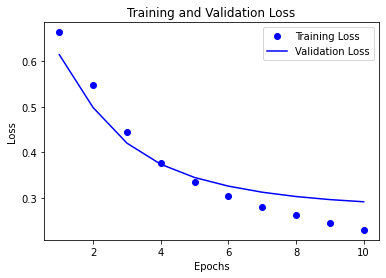

In [31]:
acc = history_dict['binary_accuracy']
val_ac = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

#'bo' is for blue dot
plt.plot(epochs, loss, 'bo', label='Training Loss')
#b is for solid blue line

plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

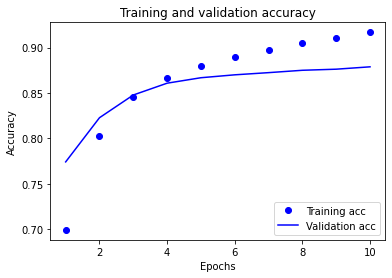

In [34]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_ac, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


# Export the mode

In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [40]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model, layers.Activation('sigmoid')
])


export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
    
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 6s 7ms/step - loss: 0.2306 - accuracy: 0.9148
0.9147999882698059


In [41]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 129ms/step


array([[0.6123387 ],
       [0.4340306 ],
       [0.35004792]], dtype=float32)